In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
# Read dataset file
df = pd.read_csv('Suzuki.csv', delimiter=";")
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [3]:
print(df.dtypes)

Date      object
Price     object
Open      object
High      object
Low       object
Volume    object
Change    object
dtype: object


In [4]:
df['Price'] = df['Price'].str.replace(',', '.').astype(float)
df['Open'] = df['Open'].str.replace(',', '.').astype(float)
df['High'] = df['High'].str.replace(',', '.').astype(float)
df['Low'] = df['Low'].str.replace(',', '.').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '.').astype(float)
df['Change'] = df['Change'].str.replace(',', '.').astype(float)

print(df)
df.describe()

            Date   Price    Open    High     Low     Volume  Change
0     04/01/2018  6742.0  6600.0  6744.0  6588.0  1940000.0  0.0318
1     05/01/2018  6740.0  6742.0  6775.0  6681.0  2010000.0 -0.0003
2     09/01/2018  6653.0  6800.0  6811.0  6648.0  2100000.0 -0.0129
3     10/01/2018  6666.0  6650.0  6699.0  6636.0  1070000.0  0.0020
4     11/01/2018  6564.0  6634.0  6644.0  6528.0  1660000.0 -0.0153
...          ...     ...     ...     ...     ...        ...     ...
1447  08/12/2023  5744.0  5732.0  5769.0  5679.0  2320000.0 -0.0250
1448  11/12/2023  5742.0  5724.0  5782.0  5708.0  1490000.0 -0.0003
1449  12/12/2023  5639.0  5800.0  5818.0  5638.0  1760000.0 -0.0179
1450  13/12/2023  5682.0  5600.0  5696.0  5545.0  1940000.0  0.0076
1451  14/12/2023  5461.0  5566.0  5595.0  5436.0  2310000.0 -0.0389

[1452 rows x 7 columns]


,Price,Open,High,Low,Volume,Change
count,1452.000000,1452.000000,1452.000000,1452.000000,1.452000e+03,1452.000000
mean,4968.014807,4971.077135,5025.840220,4914.231061,1.824907e+06,0.000106
std,833.802239,836.965130,837.524591,833.583430,8.684992e+05,0.021457
min,2465.500000,2469.500000,2551.500000,2438.000000,4.430000e+05,-0.139700
25%,4493.250000,4500.000000,4566.000000,4451.750000,1.260000e+06,-0.011725
50%,4867.500000,4870.500000,4921.500000,4818.500000,1.630000e+06,0.000000
75%,5424.250000,5423.500000,5504.250000,5367.000000,2.140000e+06,0.011700
max,7639.000000,7613.000000,7680.000000,7494.000000,9.980000e+06,0.111500


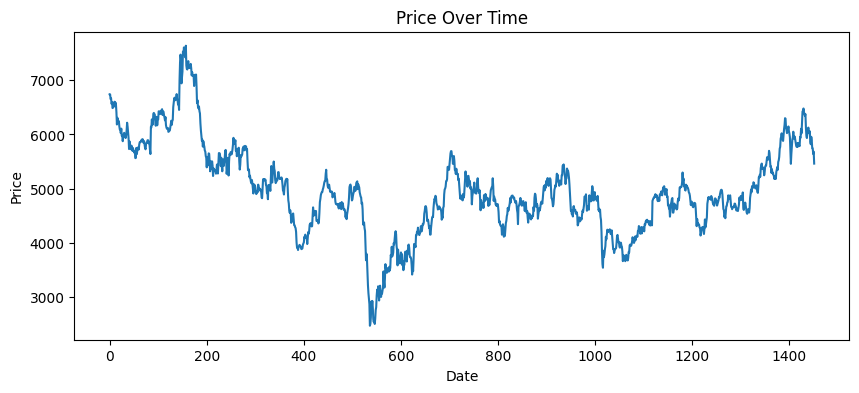

In [5]:
# Assuming you have a DataFrame 'df' with a 'Price' column
plt.figure(figsize=(10, 4))
plt.plot(df['Price'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
# Split the data into training & testing sets by 7:3
train_size = int(0.8 * len(df['Price']))
test_size = len(df['Price']) - train_size

train_data = df[:train_size]
test_data = df[train_size:train_size + test_size]

In [7]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14052.733, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14046.741, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14048.686, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14048.691, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14045.130, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14050.290, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.627 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
# make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [9]:
# 6. Create index next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

In [10]:
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - y_test))
print("Testing MAE:", test_mae)

def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    loss = np.where(is_small_error, squared_loss, linear_loss)
    return np.mean(loss)

# Calculate Huber Loss for the testing set
test_huber_loss = huber_loss(y_test, y_pred, delta=1.0)
print("Testing Huber Loss:", test_huber_loss)

Testing RMSE: 814.9182384725409
Testing MAPE: 11.229883007758898
Testing MAE: 623.0481099656357
Testing Huber Loss: 622.5481099656357


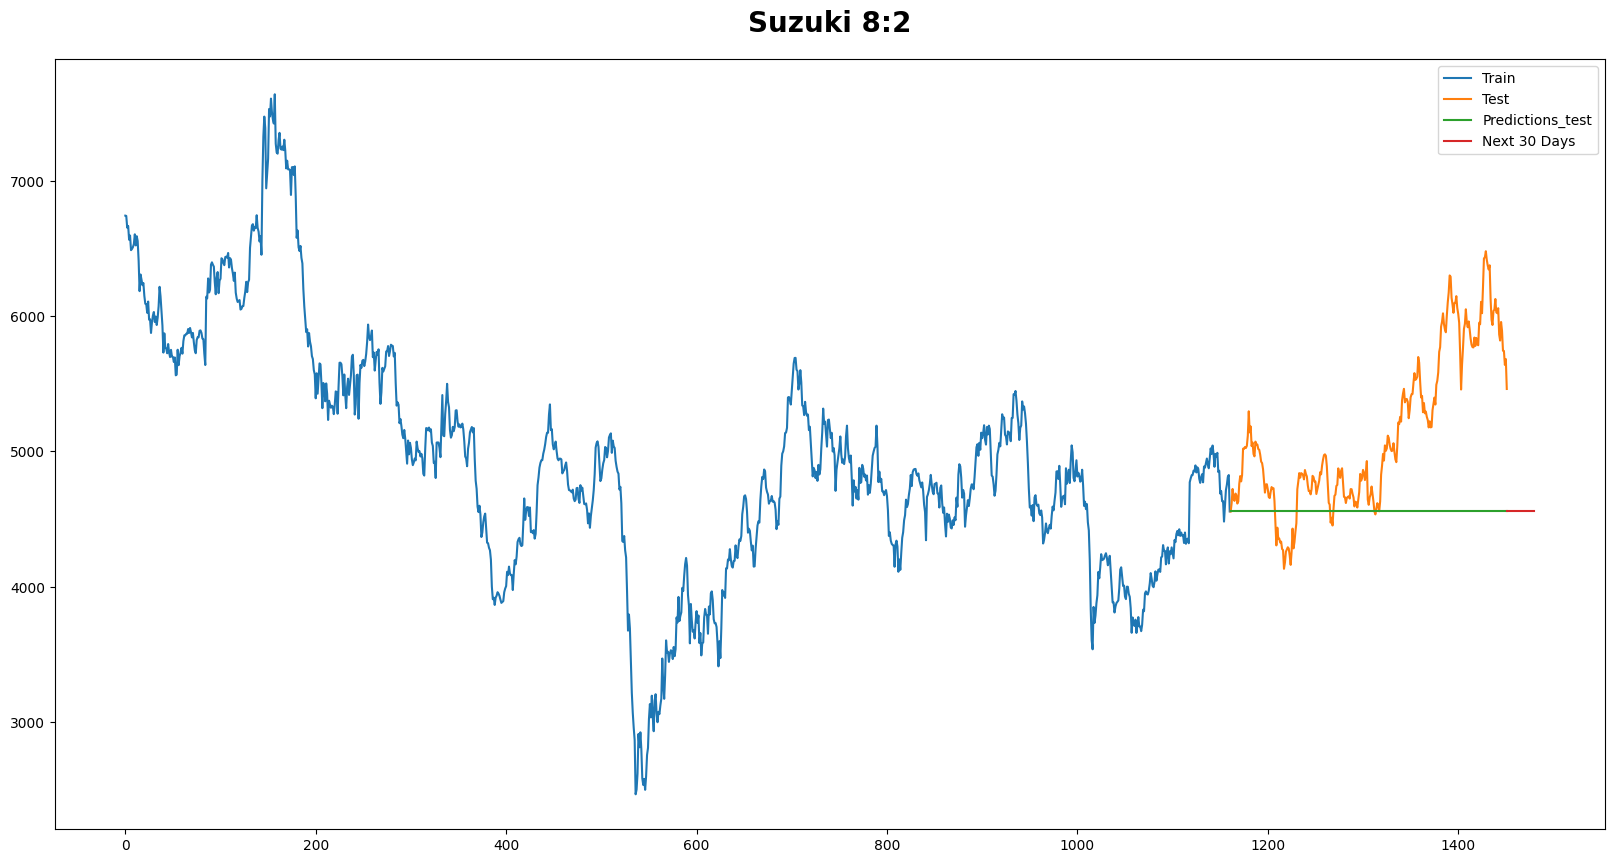

In [11]:
# Plotting the actual values and predicted values
plt.figure(figsize=(20, 10))

# Plot train data
plt.plot(train_data.index, train_data['Price'], label='Train')

# Plot test data
plt.plot(test_data.index, test_data['Price'], label='Test')

# Plot predicted values for the test set
plt.plot(test_data.index, y_pred, label='Predictions_test')

# Plot predicted values for the next 30 days
plt.plot(last_data, y_next_30_days, label='Next 30 Days')

plt.title('Suzuki 8:2', fontweight='bold', fontsize=20, pad=20)
plt.legend()
plt.show()
